Disclaimer: 
This colab is based on the notebook published on Kaggle. The original version can be found [here](https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b#Feature-Scaling) 

<b>Problem Statement:</b> <p> Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use. </p>

<p>According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.</p>

<b>Goal: </b> <p>
The goal of this competition is to predict the energy consumption using building characteristics and climate and weather variables. </p>

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)

## Loading Files and Explorative Data Analysis

In [ ]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
# check the size of train and test sets
print("Number of train samples are", data.shape)
print("Number of test samples are", test_data.shape)

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [ ]:
# initial look at the train data
data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [ ]:
# drop the id column from train data
del data['id']

In [ ]:
data.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395


In [ ]:
# find the correlation among the features
data.corr(method = 'pearson')

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
Year_Factor,1.000000,-0.036363,0.084143,-0.005052,0.132855,0.007913,-0.099628,-0.291137,-0.391312,-0.101799,-0.093735,-0.054079,0.051545,0.167406,-0.463176,-0.164931,-0.212332,-0.274205,-0.196895,0.114799,-0.309140,-0.097698,-0.406461,-0.103637,-0.190931,-0.408861,-0.072133,0.171693,0.338786,0.095091,0.180126,-0.078937,-0.097073,-0.144199,-0.062649,0.148017,0.360374,0.355420,-0.260890,-0.119175,-0.323793,0.032302,0.068750,-0.124418,0.182135,0.087389,-0.058627,0.137436,0.260270,0.263467,0.209500,0.185233,0.054718,-0.043701,-0.013635,0.231525,0.214651,0.233857,0.619227,-0.045179
floor_area,-0.036363,1.000000,0.100878,0.034947,0.097797,-0.148467,-0.137654,-0.104118,-0.106110,-0.120068,-0.042102,-0.121068,-0.098905,-0.011865,-0.087472,-0.100034,-0.030368,-0.057491,0.011626,0.028982,-0.023443,0.056028,0.026853,-0.009108,0.039562,0.021832,-0.007137,0.038335,0.023841,-0.013697,0.046048,0.055891,-0.102459,-0.059559,0.020746,-0.112179,-0.071890,0.026904,-0.085844,-0.059289,0.004669,0.045823,0.130198,0.062634,0.092503,0.074091,-0.111303,0.136123,0.135476,0.138712,0.140324,0.049897,0.022583,-0.031415,-0.009205,-0.000018,-0.003984,-0.000922,0.014282,0.073967
year_built,0.084143,0.100878,1.000000,-0.073857,0.047803,-0.011210,-0.032846,-0.080230,-0.000619,-0.020201,0.010372,-0.045171,-0.029848,-0.002352,-0.045250,-0.077966,-0.000861,-0.097668,-0.079245,-0.051633,-0.081202,-0.031165,0.006919,-0.093093,-0.052909,-0.036653,-0.103230,-0.048845,0.015295,-0.122823,-0.092156,-0.102312,-0.066947,-0.126027,-0.104420,-0.061495,-0.066770,-0.009608,-0.068626,-0.075244,-0.077388,-0.065614,0.073192,0.051926,-0.049473,-0.048279,-0.112555,0.046627,0.041619,0.063447,0.053247,-0.035519,-0.005065,-0.054164,NaN,0.001168,-0.009591,0.004945,0.084167,0.017162
energy_star_rating,-0.005052,0.034947,-0.073857,1.000000,-0.016783,0.144452,0.149421,0.081703,0.126411,0.137479,0.104399,0.134648,0.137160,0.077333,0.105996,0.100951,0.101430,-0.021194,-0.072969,0.005743,-0.039391,-0.106010,0.056200,-0.093468,-0.107087,-0.006585,-0.080867,-0.093280,-0.027211,-0.047610,-0.087785,-0.062982,0.076621,0.049684,0.037285,0.096028,0.067282,-0.012538,0.024659,0.026105,-0.050553,-0.098710,-0.133304,-0.109899,-0.140722,-0.111075,0.086425,-0.132442,-0.113404,-0.076361,-0.019048,-0.074993,0.019541,0.059382,NaN,-0.000992,0.002014,-0.000333,0.019387,-0.511012
ELEVATION,0.132855,0.097797,0.047803,-0.016783,1.000000,-0.255502,-0.233452,-0.345130,-0.153185,-0.184543,0.027383,-0.285815,-0.112014,0.068679,-0.176678,-0.258460,0.069062,-0.297420,-0.133906,0.075345,-0.416738,-0.080968,0.168690,-0.430781,-0.187750,-0.126061,-0.370227,-0.106940,0.059348,-0.204802,-0.014956,0.029897,-0.205325,-0.179472,-0.021019,-0.293057,-0.074790,0.206576,-0.399870,-0.276819,-0.207183,-0.109070,0.264434,-0.043577,0.009727,0.046208,-0.326495,0.309669,0.395252,0.561204,0.618740,0.062014,0.184423,0.104934,0.077188,0.050804,0.074144,0.040172,0.495345,0.011798
january_min_temp,0.007913,-0.148467,-0.011210,0.144452,-0.255502,1.000000,0.971149,0.658252,0.812591,0.857222,0.528175,0.

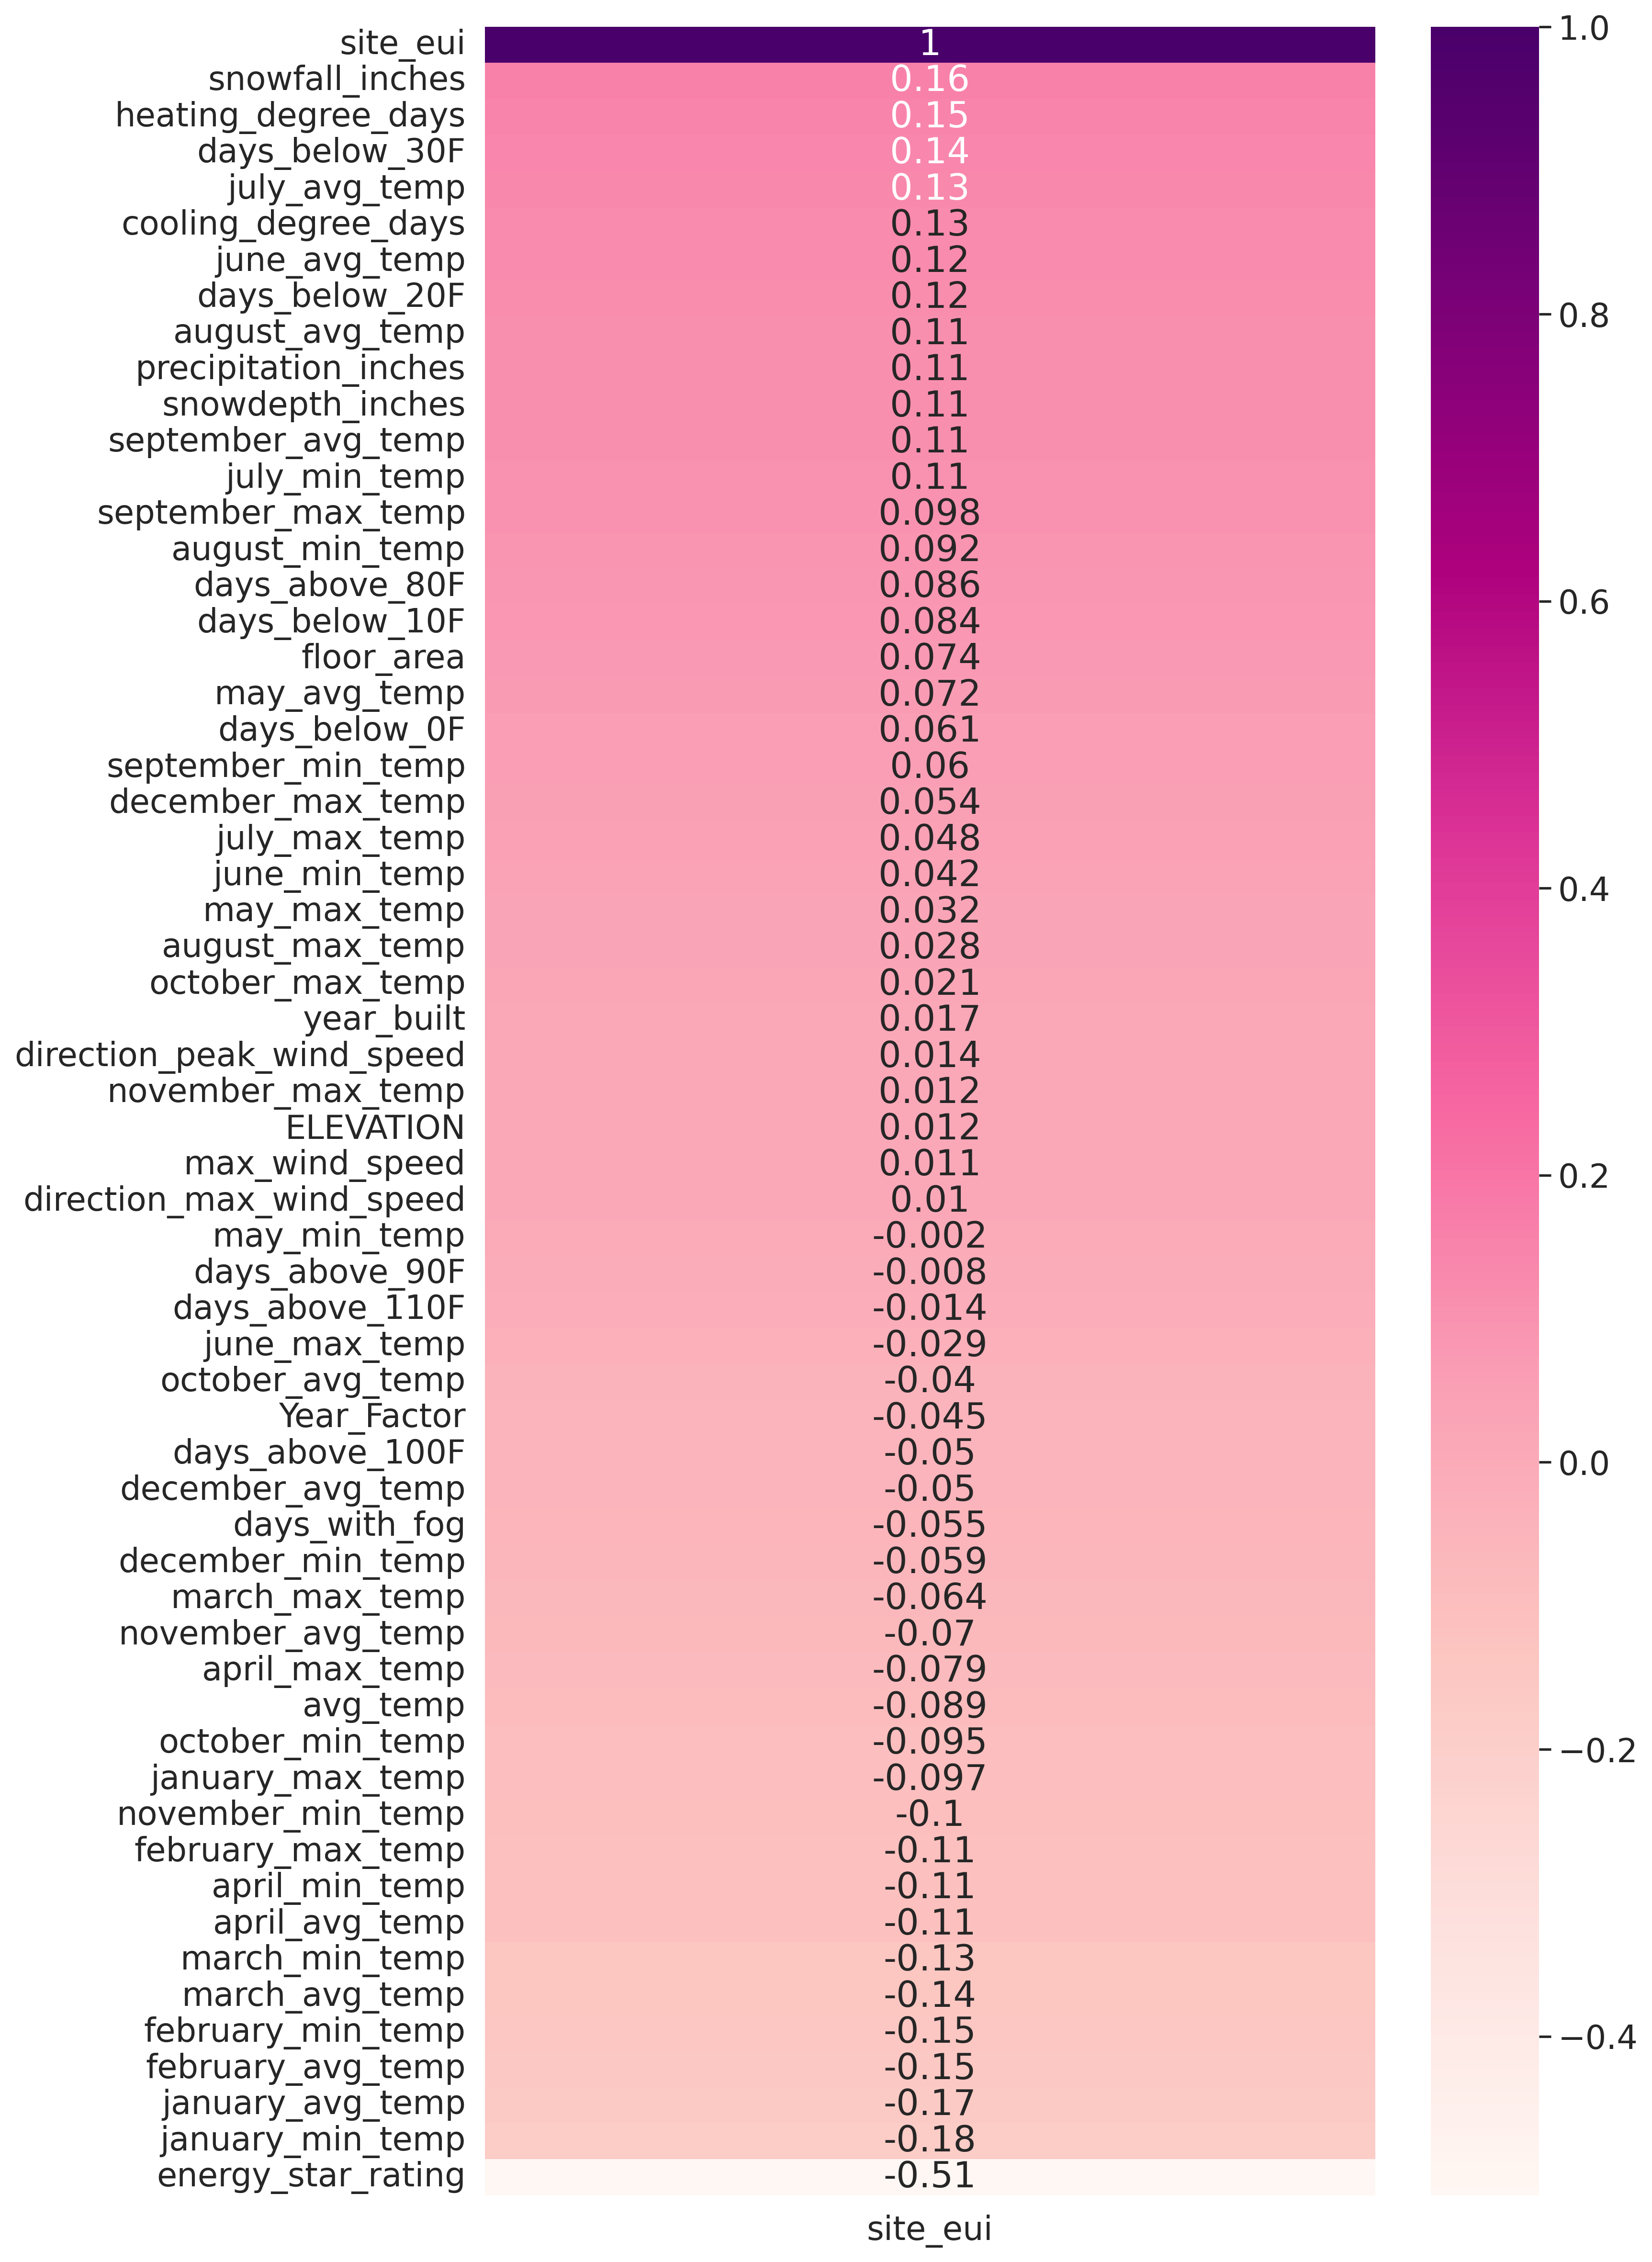

In [ ]:
ix = data.corr().sort_values('site_eui', ascending=False).index
data_sorted = data.loc[:, ix]

plt.figure(figsize=(10,20), dpi=300)
sns.heatmap(data_sorted.corr()[['site_eui']],
            cmap="RdPu",
            annot=True);

In [ ]:
# drop direction_peak_wind_speed, direction_max_wind_speed, days_with_fog, max_wind_speed from training data
del data['direction_max_wind_speed']
del data['direction_peak_wind_speed']
del data['days_with_fog']
del data['max_wind_speed']

In [ ]:
# drop direction_peak_wind_speed, direction_max_wind_speed, days_with_fog, max_wind_speed from testing data
del test_data['direction_max_wind_speed']
del test_data['direction_peak_wind_speed']
del test_data['days_with_fog']
del test_data['max_wind_speed']

In [ ]:
# the list of the comments in the training data
data.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [ ]:
data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395


In [ ]:
data.dropna(subset = ['year_built'], inplace = True, axis = 0)

In [ ]:
#test_data.dropna(subset = ['year_built'], inplace = True, axis = 0)

In [ ]:
test_data.shape

(9705, 59)

In [ ]:
new_data= data[['year_built','ELEVATION','floor_area','energy_star_rating']]

In [ ]:
new_test_data = test_data[['year_built','ELEVATION','floor_area','energy_star_rating']]

In [ ]:
knnimpute = KNNImputer(n_neighbors=5)


In [ ]:
knnimpute_test = KNNImputer(n_neighbors=5)

In [ ]:
energy_imputed = pd.DataFrame(knnimpute.fit_transform(new_data), columns = new_data.columns, index=new_data.index)

In [ ]:
energy_imputed_test = pd.DataFrame(knnimpute_test.fit_transform(new_test_data), columns = new_test_data.columns, index=new_test_data.index)

In [ ]:
energy_imputed['energy_star_rating'].isna().sum()

0

In [ ]:
energy_imputed_test['energy_star_rating'].isna().sum()

0

In [ ]:
energy_imputed.rename(columns = {'energy_star_rating': 'energy_star_rating_imputed'},inplace = True)

In [ ]:
energy_imputed_test.rename(columns = {'energy_star_rating': 'energy_star_rating_imputed'},inplace = True)

In [ ]:
energy_imputed_test.head(5)

,year_built,ELEVATION,floor_area,energy_star_rating_imputed
0,1994.0,2.4,28484.0,37.0
1,1961.0,45.7,21906.0,55.0
2,1950.0,59.1,16138.0,1.0
3,1971.0,35.4,97422.0,34.0
4,1942.0,1.8,61242.0,35.0


In [ ]:
energy_imputed.head(5)

,year_built,ELEVATION,floor_area,energy_star_rating_imputed
0,1942.0,2.4,61242.0,11.0
1,1955.0,1.8,274000.0,45.0
2,1951.0,1.8,280025.0,97.0
3,1980.0,1.8,55325.0,46.0
4,1985.0,2.4,66000.0,100.0


In [ ]:
data = data.drop(["energy_star_rating"], axis=1)

In [ ]:
test_data = test_data.drop(["energy_star_rating"], axis=1)

In [ ]:
energy_imputed_2 = energy_imputed['energy_star_rating_imputed']
data2 = pd.concat([data, energy_imputed_2], axis=1)

In [ ]:
energy_imputed_2_test = energy_imputed_test['energy_star_rating_imputed']
data2_test = pd.concat([test_data, energy_imputed_2_test], axis=1)

In [ ]:
data2.to_csv('data2.csv')

In [ ]:
data2_test.to_csv('data2_test.csv')

In [ ]:
data = pd.read_csv("data2.csv",index_col=0)
test_data = pd.read_csv("data2_test.csv",index_col=0)

In [ ]:
data.shape

(73920, 59)

In [ ]:
test_data.shape

(9705, 59)

In [ ]:
data.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,energy_star_rating_imputed
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,11.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,45.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,97.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926,46.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395,100.0


In [ ]:
test_data.shape

(9705, 59)

In [ ]:
test_data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,id,energy_star_rating_imputed
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75757,37.0
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75758,55.0
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75759,1.0
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75760,34.0
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75761,35.0


In [ ]:
data.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,energy_star_rating_imputed
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,11.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,45.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,97.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926,46.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395,100.0


In [ ]:
data['facility_type'].value_counts()

Multifamily_Uncategorized                    39072
Office_Uncategorized                         12258
Education_Other_classroom                     3823
Lodging_Hotel                                 2026
2to4_Unit_Building                            1892
Commercial_Other                              1680
5plus_Unit_Building                           1272
Warehouse_Nonrefrigerated                     1214
Retail_Uncategorized                          1085
Education_College_or_university               1030
Nursing_Home                                   748
Mixed_Use_Commercial_and_Residential           669
Lodging_Dormitory_or_fraternity_sorority       659
Warehouse_Distribution_or_Shipping_center      598
Warehouse_Selfstorage                          555
Office_Medical_non_diagnostic                  439
Grocery_store_or_food_market                   436
Religious_worship                              390
Health_Care_Inpatient                          382
Industrial                     

In [ ]:
data.Year_Factor = data.Year_Factor.astype('object')

In [ ]:
test_data.Year_Factor = test_data.Year_Factor.astype('object')

In [ ]:
test_data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,id,energy_star_rating_imputed
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75757,37.0
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75758,55.0
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75759,1.0
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75760,34.0
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75761,35.0


In [ ]:
len(data)

73920

In [ ]:

q99 = data.site_eui.quantile(q=[0.99])[0.99]

data = data[data.site_eui<q99]

In [ ]:
data.shape

(73180, 59)

In [ ]:
y = data["site_eui"]
X = data.drop(["site_eui"], axis=1)

In [ ]:
X.shape

(73180, 58)

In [ ]:
categorical_cols = ['building_class','facility_type','State_Factor','Year_Factor']

In [ ]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
X_cat = X[categorical_cols]
ohe = OneHotEncoder(drop = 'first',handle_unknown="ignore")
X_onehot = ohe.fit_transform(X_cat)
X_onehot = pd.DataFrame(X_onehot.toarray(), columns=ohe.get_feature_names_out(),index = X_cat.index)

X = pd.concat([X.drop(categorical_cols, axis=1), X_onehot], axis=1)



In [ ]:
X_onehot.shape

(73180, 71)

In [ ]:
X.shape

(73180, 125)

In [ ]:
X.shape

(73180, 125)

In [ ]:

X_cat = test_data[categorical_cols]
test_data_onehot = ohe.transform(X_cat)
test_data_onehot = pd.DataFrame(
    test_data_onehot.toarray(), columns=ohe.get_feature_names_out(), index = X_cat.index
)
test_data = pd.concat(
    [test_data.drop(categorical_cols, axis=1), test_data_onehot], axis=1
)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [ ]:
test_data_onehot.shape

(9705, 71)

In [ ]:
test_data.shape

(9705, 126)

In [ ]:
test_data_id = test_data['id']

In [ ]:
test_data_id

0       75757
1       75758
2       75759
3       75760
4       75761
        ...  
9700    85457
9701    85458
9702    85459
9703    85460
9704    85461
Name: id, Length: 9705, dtype: int64

In [ ]:
test_data.set_index('id')


,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,...,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
75757,28484.0,1994.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75758,21906.0,1961.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75759,16138.0,1950.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75760,97422.0,1971.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75761,61242.0,1942.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
test_data.shape

(9705, 126)

In [ ]:
test_data.isna().sum()

floor_area           0
year_built          92
ELEVATION            0
january_min_temp     0
january_avg_temp     0
                    ..
Year_Factor_2        0
Year_Factor_3        0
Year_Factor_4        0
Year_Factor_5        0
Year_Factor_6        0
Length: 126, dtype: int64

In [ ]:
test_data = test_data.drop(["id"], axis=1)

In [ ]:
test_data.shape

(9705, 125)

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [ ]:
imp_freq.fit(test_data)

SimpleImputer(strategy='most_frequent')

In [ ]:
imp_freq.transform(test_data)

array([[2.8484e+04, 1.9940e+03, 2.4000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1906e+04, 1.9610e+03, 4.5700e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.6138e+04, 1.9500e+03, 5.9100e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [4.2393e+04, 2.0140e+03, 8.1200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5368e+04, 1.9920e+03, 8.1200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.5640e+04, 1.9940e+03, 2.6500e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [ ]:
year_imputed_test = pd.DataFrame(imp_freq.transform(test_data), columns = test_data.columns, index=test_data.index)

In [ ]:
year_imputed_test.shape

(9705, 125)

In [ ]:
year_imputed_test.isna().sum()

floor_area          0
year_built          0
ELEVATION           0
january_min_temp    0
january_avg_temp    0
                   ..
Year_Factor_2       0
Year_Factor_3       0
Year_Factor_4       0
Year_Factor_5       0
Year_Factor_6       0
Length: 125, dtype: int64

In [ ]:
year_imputed_test.to_csv('year_imputed_test.csv')

In [ ]:
sample_solution = pd.read_csv('/content/sample_solution.csv')

In [ ]:
type(sample_solution)

pandas.core.frame.DataFrame

In [ ]:
sample_solution.head(20)

,id,site_eui
0,75757,0.0
1,75758,0.0
2,75759,0.0
3,75760,0.0
4,75761,0.0
5,75762,0.0
6,75763,0.0
7,75764,0.0
8,75765,0.0
9,75766,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_data)

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=50
)

Baseline Model

In [ ]:
from sklearn.dummy import DummyRegressor

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
DummyRegressor()
dummy_regr.predict(X_test)

dummy_regr.score(X_test, y_test)


-1.4978422375078182e-05

Best Model

In [ ]:
import lightgbm

In [ ]:
best_model = lightgbm.LGBMRegressor(learning_rate=0.1, max_depth=-1,
                                    n_estimators= 1000, num_leaves = 100, reg_alpha = 0.05)
# Fit X_scaled and y
best_model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, num_leaves=100, reg_alpha=0.05)

In [ ]:
best_model.score(X_test,y_test)

0.6092859014925598

In [ ]:
solution = best_model.predict(year_imputed_test)

In [ ]:
len(solution)

9705

In [ ]:
solution = pd.DataFrame(solution, columns = ['site_eui'], index = year_imputed_test.index)

In [ ]:
solution['id'] = test_data_id

In [ ]:
solution

,site_eui,id
0,154.042519,75757
1,146.923656,75758
2,174.220396,75759
3,146.923656,75760
4,154.061575,75761
...,...,...
9700,54.841609,85457
9701,54.841609,85458
9702,54.841609,85459
9703,54.841609,85460


In [ ]:
solution_columns = ['id','site_eui']

In [ ]:
solution = solution[solution_columns]

In [ ]:
solution

,id,site_eui
0,75757,154.042519
1,75758,146.923656
2,75759,174.220396
3,75760,146.923656
4,75761,154.061575
...,...,...
9700,85457,54.841609
9701,85458,54.841609
9702,85459,54.841609
9703,85460,54.841609


In [ ]:
type(solution)

pandas.core.frame.DataFrame

In [ ]:
solution.to_csv('solution.csv')

Ridge Regression

Grid Search on Random Forest

In [ ]:
grid = {
 'max_depth': [1,2,3,5,7],
 'max_features': ['sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

In [ ]:
forest_reg = RandomForestRegressor(random_state = 42)
forest_cv = GridSearchCV(estimator = forest_reg, param_grid = grid, cv = 10,verbose = 1)
forest_cv.fit(X_train,y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [ ]:
print("tuned hyperparameters :(best parameters) ",forest_cv.best_params_)
print("r2 :",forest_cv.best_score_)